In [1]:
import copy
from pathlib import Path
import warnings
import os

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
import tensorboard as tb

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE, QuantileLoss, MultivariateNormalDistributionLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data import TorchNormalizer

from dataloader import TimeSeriesLoader

In [2]:
# suppose the raw dataset is downloaded and unzipped under Open-source-power-dataset
# data loaders are iterable
loader = TimeSeriesLoader(task='forecasting', root='../PSML')
train_loader, test_loader = loader.load(batch_size=32, shuffle=True)

0/66


In [66]:
device = 'cuda'

# Process

1. Shape dataset (from csvs) per instrucitons in `pytorch-forecasting` docs into a `TimeSeriesDataset`
2. Batch via DataLoader per tutorial

In [2]:
data_original = pd.read_csv('../PSML/Minute-level Load and Renewable/CAISO_zone_1_.csv')

In [3]:
data_original.shape

(1573923, 12)

In [87]:
root = '../PSML'
data_folder = os.path.join(root, 'processed_dataset', 'forecasting')
location = 'CAISO_zone_1'
years = ['2018', '2019', '2020']

data = pd.DataFrame()
data_dfs = []

for year in years:
    data_append = pd.read_csv(os.path.join(data_folder, f'{location}_{year}.csv'))
    
    # turn holiday into categorical
    data_append['holiday'] = pd.Categorical(data_append['holiday'].astype(str))
    data_append['weekday'] = pd.Categorical(data_append['weekday'].astype(str))
    data_append['constant'] = 'filler'
    
    data_dfs.append(data_append)
    data = pd.concat((data, data_append), ignore_index=True)

data_2018 = data_dfs[0]
data_2019 = data_dfs[1]
data_2020 = data_dfs[2]
data['ID'] = data.index
data

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag,constant
0,0,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.880,1.2,...,1.0,0.005297,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
1,1,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.842,1.2,...,1.0,0.005203,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
2,2,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.804,1.2,...,1.0,0.005109,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
3,3,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.766,1.2,...,1.0,0.005015,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
4,4,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.728,1.2,...,1.0,0.004921,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573918,1573918,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,169.010,0.8,...,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,filler
1573919,1573919,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.990,0.8,...,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,filler
1573920,1573920,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.970,0.8,...,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,filler
1573921,1573921,12.967742,2.0,0.0,0.0,0.0,0.0,-7.8,168.950,0.8,...,0.0,-1.000000,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,filler


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573923 entries, 0 to 1573922
Data columns (total 29 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   ID                  1573923 non-null  int64   
 1   month_day           1573923 non-null  float64 
 2   weekday             1573923 non-null  category
 3   holiday             1573923 non-null  category
 4   DHI                 1573923 non-null  float64 
 5   DNI                 1573923 non-null  float64 
 6   GHI                 1573923 non-null  float64 
 7   Dew Point           1573923 non-null  float64 
 8   Solar Zenith Angle  1573923 non-null  float64 
 9   Wind Speed          1573923 non-null  float64 
 10  Relative Humidity   1573923 non-null  float64 
 11  Temperature         1573923 non-null  float64 
 12  yl_t                1573923 non-null  float64 
 13  yl_t+60(val)        1573923 non-null  float64 
 14  yl_t+60(flag)       1573923 non-null  float64 
 15

Pick one of the tasks and train a model based on it. We'll use hourly load prediction.

In [89]:
data['holiday']

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
1573918    0.0
1573919    0.0
1573920    0.0
1573921    0.0
1573922    0.0
Name: holiday, Length: 1573923, dtype: category
Categories (2, object): ['0.0', '1.0']

In [133]:
time_col = 'ID'
target_y_flag = 'yl_t+60(flag)'
target_y = 'yl_t+60(val)'
data_yl_t60 = data_2018[data_2018[target_y_flag] == 1].reset_index(drop=True)
# data_yl_t60 = data_2018.reset_index(drop=True)
data_yl_t60['ID'] = data_yl_t60.index
data_yl_t60

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag,constant
0,0,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.88,1.2,...,1.0,0.005297,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
1,1,1.032258,0.0,1.0,0.0,0.0,0.0,-8.4,161.76,1.2,...,1.0,0.005360,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
2,2,1.032258,0.0,1.0,0.0,0.0,0.0,-9.2,150.28,1.3,...,1.0,0.005413,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
3,3,1.032258,0.0,1.0,0.0,0.0,0.0,-9.9,137.98,1.4,...,1.0,0.006356,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
4,4,1.032258,0.0,1.0,0.0,0.0,0.0,-10.4,125.56,1.5,...,1.0,0.007392,1.0,0.0,0.0,0.0,0.0,0.0,1.0,filler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,8730,12.967742,6.0,0.0,0.0,0.0,0.0,6.5,116.08,1.1,...,1.0,0.005245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,filler
8731,8731,12.967742,6.0,0.0,0.0,0.0,0.0,7.0,128.39,1.0,...,1.0,0.003749,1.0,0.0,0.0,0.0,0.0,0.0,0.0,filler
8732,8732,12.967742,6.0,0.0,0.0,0.0,0.0,7.3,140.80,1.4,...,1.0,0.008951,1.0,0.0,0.0,0.0,0.0,0.0,0.0,filler
8733,8733,12.967742,6.0,0.0,0.0,0.0,0.0,7.1,153.02,1.6,...,1.0,0.010854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,filler


In [182]:
dataset_df = data_yl_t60
train_cutoff_idx = dataset_df[dataset_df['month_day'] >= 10][time_col].values[0]
val_cutoff_idx = dataset_df[dataset_df['month_day'] >= 12][time_col].values[0]
print('training cutoff idx:', train_cutoff_idx)
print('validation cutoff idx:', val_cutoff_idx)

training cutoff idx: 6552
validation cutoff idx: 8015


In [138]:
dataset_df.groupby(target_y).count().sort_values('ID', ascending=False)

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,...,yw_t+5(flag),yw_t+30(val),yw_t+30(flag),ys_t,ys_t+5(val),ys_t+5(flag),ys_t+30(val),ys_t+30(flag),train_flag,constant
yl_t+60(val),,,,,,,,,,,,,,,,,,,,,
0.788434,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
0.752175,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
0.737033,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
0.850957,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
0.932787,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.908638,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.908400,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.908310,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [139]:
dataset_df.iloc[:, :14]

,ID,month_day,weekday,holiday,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,Relative Humidity,Temperature,yl_t,yl_t+60(val)
0,0,1.032258,0.0,1.0,0.0,0.0,0.0,-7.7,168.88,1.2,23.78,12.5,0.785327,0.751928
1,1,1.032258,0.0,1.0,0.0,0.0,0.0,-8.4,161.76,1.2,22.59,12.4,0.751928,0.726002
2,2,1.032258,0.0,1.0,0.0,0.0,0.0,-9.2,150.28,1.3,21.91,11.9,0.726002,0.712764
3,3,1.032258,0.0,1.0,0.0,0.0,0.0,-9.9,137.98,1.4,22.24,10.9,0.712764,0.710416
4,4,1.032258,0.0,1.0,0.0,0.0,0.0,-10.4,125.56,1.5,22.26,10.3,0.710416,0.729610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,8730,12.967742,6.0,0.0,0.0,0.0,0.0,6.5,116.08,1.1,98.14,6.8,0.979627,0.962109
8731,8731,12.967742,6.0,0.0,0.0,0.0,0.0,7.0,128.39,1.0,100.00,7.0,0.962109,0.926617
8732,8732,12.967742,6.0,0.0,0.0,0.0,0.0,7.3,140.80,1.4,93.98,8.2,0.926617,0.878301
8733,8733,12.967742,6.0,0.0,0.0,0.0,0.0,7.1,153.02,1.6,91.09,8.5,0.878301,0.820347


In [153]:
max_prediction_length = 24
max_encoder_length = 48
training_cutoff = train_cutoff_idx - max_prediction_length

training = TimeSeriesDataSet(
    dataset_df[lambda x: x[time_col] <= training_cutoff],
    time_idx=time_col,
    target=target_y,
    group_ids=['constant'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=['holiday', 'weekday'],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=['month_day'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'DHI',
        'DNI',
        'GHI',
        'Dew Point',
        'Solar Zenith Angle',
        'Wind Speed',
        'Relative Humidity',
        'Temperature',
        target_y,
    ],
#     target_normalizer=TorchNormalizer(
#         method='identity', center=True, transformation=None, method_kwargs={}
#     ), # https://github.com/jdb78/pytorch-forecasting/issues/1220
#     add_relative_time_idx=True,
    add_target_scales=True,
#     add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training,
    dataset_df,
    predict=True,
    stop_randomization=True,
    min_prediction_idx=train_cutoff_idx + 1,
)
testing = TimeSeriesDataSet.from_dataset(
    training,
    dataset_df,
    predict=True,
    stop_randomization=True,
    min_prediction_idx=val_cutoff_idx - 1,
)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, pin_memory=True, batch_sampler='synchronized')
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0, pin_memory=True, batch_sampler='synchronized')
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0, pin_memory=True, batch_sampler='synchronized')

In [154]:
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(device)
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)]).to(device)

In [155]:
val_actuals.get_device()

0

In [156]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"))

rmse = RMSE().to(device)
print(rmse(baseline_predictions, val_actuals))

mae = MAE().to(device)
print(mae(baseline_predictions, val_actuals))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.0795, device='cuda:0')
tensor(0.0654, device='cuda:0')


### Find optimal learning rate

1st Optuna study results:

```
{'gradient_clip_val': 0.07722552005774576, 'hidden_size': 11, 'dropout': 0.2016589910911832, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.027542287033381664}
```

In [172]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.077,
)

# filled in with HPs from HP tuning
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.0275,
    hidden_size=11,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.12,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=1,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger",
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42


Number of parameters in network: 9.6k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 1.8197008586099834e-05


suggested learning rate: 1.8197008586099834e-05


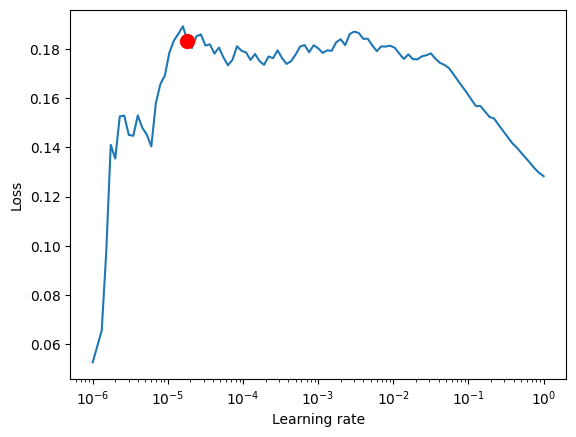

In [173]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

# minor precision sacrifice for major performance gains on CUDA-enabled GPU
torch.set_float32_matmul_precision('high')

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [174]:
optimal_lr = 0.0275

In [175]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=25,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    limit_val_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    enable_checkpointing=True,
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=optimal_lr,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 23.6k


In [176]:
# fit network

# minor precision sacrifice for major performance gains on CUDA-enabled GPU
torch.set_float32_matmul_precision('high')

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 37    
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 768   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [177]:
# calculate mean absolute error on validation set
val_predictions = tft.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"))
print('RMSE:', rmse(val_predictions, val_actuals))
print('MAE:', mae(val_predictions, val_actuals))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: tensor(0.0909, device='cuda:0')
MAE: tensor(0.0793, device='cuda:0')


### Hyperparameter tuning

In [163]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=25,
    timeout=10000,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 164),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=50, limit_val_batches=50),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-04-30 16:28:39,485] A new study created in memory with name: no-name-3103b451-5852-4287-a709-3e1405d40138
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.006606934480075959
[I 2023-04-30 16:28:42,427] Using learning rate of 0.0457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:29:18,041] Trial 0 finished with value: 0.06610722094774246 and parameters: {'gradient_clip_val': 0.9263499090725235, 'hidden_size': 14, 'dropout': 0.23140809217227237, 'hidden_continuous_size': 12, 'attention_head_size': 4, 'learning_rate': 0.0457088189614875}. Best is trial 0 with value: 0.06610722094774246.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:29:20,760] Using learning rate of 0.00251
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:29:56,299] Trial 1 finished with value: 0.05338713526725769 and parameters: {'gradient_clip_val': 0.9613991724358169, 'hidden_size': 15, 'dropout': 0.27807987453815886, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0025118864315095803}. Best is trial 1 with value: 0.05338713526725769.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0023988329190194903
[I 2023-04-30 16:29:58,809] Using learning rate of 0.00263
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:30:30,458] Trial 2 finished with value: 0.04669110104441643 and parameters: {'gradient_clip_val': 0.832819975884385, 'hidden_size': 9, 'dropout': 0.19627885984760746, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.0026302679918953817}. Best is trial 2 with value: 0.04669110104441643.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0041686938347033535
[I 2023-04-30 16:30:33,185] Using learning rate of 0.00457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:31:07,517] Trial 3 finished with value: 0.1777513027191162 and parameters: {'gradient_clip_val': 0.05107681441924843, 'hidden_size': 17, 'dropout': 0.2333101986212694, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.00457088189614875}. Best is trial 2 with value: 0.04669110104441643.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0025118864315095803
[I 2023-04-30 16:31:10,506] Using learning rate of 0.00631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:31:47,197] Trial 4 finished with value: 0.07131209224462509 and parameters: {'gradient_clip_val': 0.14066291981364695, 'hidden_size': 91, 'dropout': 0.1562375606158691, 'hidden_continuous_size': 18, 'attention_head_size': 4, 'learning_rate': 0.006309573444801934}. Best is trial 2 with value: 0.04669110104441643.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:31:50,201] Using learning rate of 0.00525
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:32:25,433] Trial 5 finished with value: 0.06955458968877792 and parameters: {'gradient_clip_val': 0.04213328053616073, 'hidden_size': 46, 'dropout': 0.291295408423604, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.0052480746024977255}. Best is trial 2 with value: 0.04669110104441643.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.00208929613085404
[I 2023-04-30 16:32:28,277] Using learning rate of 0.00219
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:33:03,512] Trial 6 finished with value: 0.052832189947366714 and parameters: {'gradient_clip_val': 0.06753009000437803, 'hidden_size': 43, 'dropout': 0.15096396541341928, 'hidden_continuous_size': 11, 'attention_head_size': 4, 'learning_rate': 0.0021877616239495525}. Best is trial 2 with value: 0.04669110104441643.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.00208929613085404
[I 2023-04-30 16:33:06,319] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:33:40,395] Trial 7 finished with value: 0.07213123142719269 and parameters: {'gradient_clip_val': 0.02741235619906133, 'hidden_size': 104, 'dropout': 0.16711348058920067, 'hidden_continuous_size': 43, 'attention_head_size': 3, 'learning_rate': 0.012022644346174132}. Best is trial 2 with value: 0.04669110104441643.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:33:43,097] Using learning rate of 0.00191
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:34:17,117] Trial 8 finished with value: 0.04836345836520195 and parameters: {'gradient_clip_val': 0.013477113053739756, 'hidden_size': 62, 'dropout': 0.14550085272367033, 'hidden_continuous_size': 53, 'attention_head_size': 1, 'learning_rate': 0.0019054607179632473}. Best is trial 2 with value: 0.04669110104441643.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:34:19,878] Using learning rate of 0.0302
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:34:53,239] Trial 9 finished with value: 0.08566153049468994 and parameters: {'gradient_clip_val': 0.052844721407648336, 'hidden_size': 18, 'dropout': 0.27010508291872903, 'hidden_continuous_size': 16, 'attention_head_size': 2, 'learning_rate': 0.03019951720402016}. Best is trial 2 with value: 0.04669110104441643.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0021877616239495525
[I 2023-04-30 16:34:55,727] Using learning rate of 0.0302
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:35:26,850] Trial 10 finished with value: 0.04596388339996338 and parameters: {'gradient_clip_val': 0.29299206524736726, 'hidden_size': 8, 'dropout': 0.10973746079643913, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.03019951720402016}. Best is trial 10 with value: 0.04596388339996338.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0033113112148259113
[I 2023-04-30 16:35:29,308] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:36:00,396] Trial 11 finished with value: 0.08082509785890579 and parameters: {'gradient_clip_val': 0.31885452264914554, 'hidden_size': 8, 'dropout': 0.10208498695856488, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.007244359600749901}. Best is trial 10 with value: 0.04596388339996338.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0021877616239495525
[I 2023-04-30 16:36:02,838] Using learning rate of 0.00479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:36:33,215] Trial 12 finished with value: 0.07991781830787659 and parameters: {'gradient_clip_val': 0.3733500050238647, 'hidden_size': 8, 'dropout': 0.1017046307033647, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.0047863009232263845}. Best is trial 10 with value: 0.04596388339996338.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:36:35,615] Using learning rate of 0.0038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:37:06,735] Trial 13 finished with value: 0.04533453285694122 and parameters: {'gradient_clip_val': 0.4063827155011876, 'hidden_size': 8, 'dropout': 0.1985285128111792, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.0038018939632056114}. Best is trial 13 with value: 0.04533453285694122.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0022908676527677732
[I 2023-04-30 16:37:09,470] Using learning rate of 0.0229
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:37:44,069] Trial 14 finished with value: 0.05484146252274513 and parameters: {'gradient_clip_val': 0.20720400912525447, 'hidden_size': 28, 'dropout': 0.12303759152915406, 'hidden_continuous_size': 10, 'attention_head_size': 2, 'learning_rate': 0.022908676527677734}. Best is trial 13 with value: 0.04533453285694122.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.002884031503126606
[I 2023-04-30 16:37:46,774] Using learning rate of 0.00479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:38:21,416] Trial 15 finished with value: 0.03844233229756355 and parameters: {'gradient_clip_val': 0.12301808227912008, 'hidden_size': 11, 'dropout': 0.18906956749652698, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.0047863009232263845}. Best is trial 15 with value: 0.03844233229756355.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:38:24,103] Using learning rate of 0.00398
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:38:58,336] Trial 16 finished with value: 0.0740065798163414 and parameters: {'gradient_clip_val': 0.11429688438696423, 'hidden_size': 12, 'dropout': 0.18840729973802847, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.0039810717055349725}. Best is trial 15 with value: 0.03844233229756355.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0023988329190194903
[I 2023-04-30 16:39:01,031] Using learning rate of 0.00251
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:39:34,221] Trial 17 finished with value: 0.08665639162063599 and parameters: {'gradient_clip_val': 0.1710736413768495, 'hidden_size': 23, 'dropout': 0.21715437106233418, 'hidden_continuous_size': 10, 'attention_head_size': 2, 'learning_rate': 0.0025118864315095803}. Best is trial 15 with value: 0.03844233229756355.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0034673685045253167
[I 2023-04-30 16:39:36,903] Using learning rate of 0.0603
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:40:10,856] Trial 18 finished with value: 0.056296456605196 and parameters: {'gradient_clip_val': 0.08148729753862388, 'hidden_size': 12, 'dropout': 0.17920930923207615, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.06025595860743578}. Best is trial 15 with value: 0.03844233229756355.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019054607179632473
[I 2023-04-30 16:40:13,525] Using learning rate of 0.00229
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:40:46,459] Trial 19 finished with value: 0.06744997948408127 and parameters: {'gradient_clip_val': 0.45714359729350057, 'hidden_size': 11, 'dropout': 0.20741815015823298, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0022908676527677732}. Best is trial 15 with value: 0.03844233229756355.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.002884031503126606
[I 2023-04-30 16:40:49,150] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:41:23,465] Trial 20 finished with value: 0.03486982360482216 and parameters: {'gradient_clip_val': 0.10865846582547616, 'hidden_size': 22, 'dropout': 0.1779190060896126, 'hidden_continuous_size': 10, 'attention_head_size': 2, 'learning_rate': 0.007244359600749901}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 16:41:26,173] Using learning rate of 0.00316
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:41:59,489] Trial 21 finished with value: 0.067261703312397 and parameters: {'gradient_clip_val': 0.09765809425944758, 'hidden_size': 22, 'dropout': 0.1822330740628271, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.0031622776601683794}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0026302679918953817
[I 2023-04-30 16:42:02,176] Using learning rate of 0.0575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:42:36,207] Trial 22 finished with value: 0.05807569995522499 and parameters: {'gradient_clip_val': 0.20468666237580885, 'hidden_size': 10, 'dropout': 0.17073606237146585, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.057543993733715694}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0018197008586099835
[I 2023-04-30 16:42:38,909] Using learning rate of 0.00631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:43:13,086] Trial 23 finished with value: 0.07894361019134521 and parameters: {'gradient_clip_val': 0.13403780301617998, 'hidden_size': 13, 'dropout': 0.19691658060360406, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.006309573444801934}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:43:15,708] Using learning rate of 0.00417
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:43:48,058] Trial 24 finished with value: 0.07560228556394577 and parameters: {'gradient_clip_val': 0.5323150152741648, 'hidden_size': 10, 'dropout': 0.2075572897424109, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0041686938347033535}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 16:43:50,725] Using learning rate of 0.011
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:44:24,563] Trial 25 finished with value: 0.0657014474272728 and parameters: {'gradient_clip_val': 0.22048615853143055, 'hidden_size': 17, 'dropout': 0.13952091545293238, 'hidden_continuous_size': 10, 'attention_head_size': 2, 'learning_rate': 0.010964781961431852}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 16:44:27,275] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:45:00,972] Trial 26 finished with value: 0.06514181941747665 and parameters: {'gradient_clip_val': 0.10718437820784195, 'hidden_size': 10, 'dropout': 0.17013130182767386, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.0016595869074375606}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0026302679918953817
[I 2023-04-30 16:45:03,639] Using learning rate of 0.0229
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:45:37,496] Trial 27 finished with value: 0.07172087579965591 and parameters: {'gradient_clip_val': 0.26233335902582483, 'hidden_size': 14, 'dropout': 0.18648951263529182, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.022908676527677734}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0047863009232263845
[I 2023-04-30 16:45:40,123] Using learning rate of 0.011
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:46:12,517] Trial 28 finished with value: 0.07967161387205124 and parameters: {'gradient_clip_val': 0.15888233889916664, 'hidden_size': 21, 'dropout': 0.1602362848979692, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.010964781961431852}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0018197008586099835
[I 2023-04-30 16:46:15,177] Using learning rate of 0.0038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:46:49,309] Trial 29 finished with value: 0.06089947745203972 and parameters: {'gradient_clip_val': 0.695207100433324, 'hidden_size': 14, 'dropout': 0.2368114470013399, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.0038018939632056114}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0017378008287493754
[I 2023-04-30 16:46:52,025] Using learning rate of 0.002
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:47:26,295] Trial 30 finished with value: 0.07554159313440323 and parameters: {'gradient_clip_val': 0.42793842253084724, 'hidden_size': 28, 'dropout': 0.21440577886174886, 'hidden_continuous_size': 12, 'attention_head_size': 3, 'learning_rate': 0.0019952623149688794}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0018197008586099835
[I 2023-04-30 16:47:28,720] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:47:58,595] Trial 31 finished with value: 0.04222936928272247 and parameters: {'gradient_clip_val': 0.3276462566640299, 'hidden_size': 8, 'dropout': 0.13159968029173139, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.015848931924611134}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 16:48:01,289] Using learning rate of 0.0166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:48:35,759] Trial 32 finished with value: 0.058894943445920944 and parameters: {'gradient_clip_val': 0.28734572990535356, 'hidden_size': 9, 'dropout': 0.13853242904758545, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.016595869074375606}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:48:38,440] Using learning rate of 0.0024
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:49:11,786] Trial 33 finished with value: 0.05624087527394295 and parameters: {'gradient_clip_val': 0.5656417961043778, 'hidden_size': 11, 'dropout': 0.1273135046368119, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.0023988329190194903}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:49:14,208] Using learning rate of 0.00398
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:49:45,103] Trial 34 finished with value: 0.05227656662464142 and parameters: {'gradient_clip_val': 0.7454308426303724, 'hidden_size': 8, 'dropout': 0.16061856805057617, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.0039810717055349725}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0025118864315095803
[I 2023-04-30 16:49:47,777] Using learning rate of 0.00263
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:50:21,615] Trial 35 finished with value: 0.0986626148223877 and parameters: {'gradient_clip_val': 0.9911064404312867, 'hidden_size': 15, 'dropout': 0.17627045315033482, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.0026302679918953817}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:50:24,248] Using learning rate of 0.0479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:50:56,639] Trial 36 finished with value: 0.0596698634326458 and parameters: {'gradient_clip_val': 0.3871269482704037, 'hidden_size': 9, 'dropout': 0.15361795759243016, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.04786300923226383}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0018197008586099835
[I 2023-04-30 16:50:59,366] Using learning rate of 0.00263
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:51:34,276] Trial 37 finished with value: 0.05768643692135811 and parameters: {'gradient_clip_val': 0.170878885495536, 'hidden_size': 12, 'dropout': 0.18780264062753443, 'hidden_continuous_size': 9, 'attention_head_size': 4, 'learning_rate': 0.0026302679918953817}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0027542287033381664
[I 2023-04-30 16:51:36,980] Using learning rate of 0.00275
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:52:10,670] Trial 38 finished with value: 0.051224734634160995 and parameters: {'gradient_clip_val': 0.2496699255981004, 'hidden_size': 16, 'dropout': 0.1929235575483921, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.0027542287033381664}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 16:52:13,347] Using learning rate of 0.00794
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:52:47,079] Trial 39 finished with value: 0.09837499260902405 and parameters: {'gradient_clip_val': 0.12482374406877336, 'hidden_size': 13, 'dropout': 0.1642052561468532, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.007943282347242816}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:52:49,822] Using learning rate of 0.00575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:53:23,703] Trial 40 finished with value: 0.08390652388334274 and parameters: {'gradient_clip_val': 0.08544539527392672, 'hidden_size': 9, 'dropout': 0.17601781265994662, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.005754399373371569}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:53:27,187] Using learning rate of 0.0457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:54:00,621] Trial 41 finished with value: 0.05508686229586601 and parameters: {'gradient_clip_val': 0.3335071518567174, 'hidden_size': 9, 'dropout': 0.11403624444878979, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.0457088189614875}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0018197008586099835
[I 2023-04-30 16:54:03,054] Using learning rate of 0.002
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:54:34,165] Trial 42 finished with value: 0.060489166527986526 and parameters: {'gradient_clip_val': 0.2922345046135332, 'hidden_size': 8, 'dropout': 0.1302299798053262, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.0019952623149688794}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.002884031503126606
[I 2023-04-30 16:54:36,590] Using learning rate of 0.038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:55:06,451] Trial 43 finished with value: 0.07297497987747192 and parameters: {'gradient_clip_val': 0.15132890639575794, 'hidden_size': 8, 'dropout': 0.14458360157400318, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.038018939632056124}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:55:09,188] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:55:44,048] Trial 44 finished with value: 0.08402421325445175 and parameters: {'gradient_clip_val': 0.35671516318180263, 'hidden_size': 10, 'dropout': 0.11451944688702809, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.0069183097091893644}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 16:55:46,756] Using learning rate of 0.012
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:56:20,361] Trial 45 finished with value: 0.05028563737869263 and parameters: {'gradient_clip_val': 0.20433723194932688, 'hidden_size': 11, 'dropout': 0.14724355839488446, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.012022644346174132}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0027542287033381664
[I 2023-04-30 16:56:23,089] Using learning rate of 0.0158
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:56:57,005] Trial 46 finished with value: 0.059352267533540726 and parameters: {'gradient_clip_val': 0.5108650069500961, 'hidden_size': 19, 'dropout': 0.1533608930154705, 'hidden_continuous_size': 11, 'attention_head_size': 2, 'learning_rate': 0.015848931924611134}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0041686938347033535
[I 2023-04-30 16:56:59,715] Using learning rate of 0.00479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:57:34,372] Trial 47 finished with value: 0.052624624222517014 and parameters: {'gradient_clip_val': 0.6286642404838975, 'hidden_size': 15, 'dropout': 0.11473439705832797, 'hidden_continuous_size': 12, 'attention_head_size': 3, 'learning_rate': 0.0047863009232263845}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:57:36,764] Using learning rate of 0.00191
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:58:06,342] Trial 48 finished with value: 0.06255429238080978 and parameters: {'gradient_clip_val': 0.46089775846717196, 'hidden_size': 8, 'dropout': 0.13345005754884276, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.0019054607179632473}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:58:09,048] Using learning rate of 0.0174
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:58:43,361] Trial 49 finished with value: 0.0721016600728035 and parameters: {'gradient_clip_val': 0.06610228405776533, 'hidden_size': 18, 'dropout': 0.19829548918939874, 'hidden_continuous_size': 11, 'attention_head_size': 3, 'learning_rate': 0.01737800828749375}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0022908676527677732
[I 2023-04-30 16:58:46,035] Using learning rate of 0.0794
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:59:18,895] Trial 50 finished with value: 0.05642518773674965 and parameters: {'gradient_clip_val': 0.3367307790442801, 'hidden_size': 9, 'dropout': 0.10509017241441271, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.07943282347242814}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0018197008586099835
[I 2023-04-30 16:59:21,326] Using learning rate of 0.00479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 16:59:52,315] Trial 51 finished with value: 0.048882126808166504 and parameters: {'gradient_clip_val': 0.6617316389854964, 'hidden_size': 8, 'dropout': 0.182158615266334, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.0047863009232263845}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 16:59:55,033] Using learning rate of 0.011
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:00:28,642] Trial 52 finished with value: 0.05758024752140045 and parameters: {'gradient_clip_val': 0.822242966768329, 'hidden_size': 11, 'dropout': 0.19148465589245534, 'hidden_continuous_size': 10, 'attention_head_size': 3, 'learning_rate': 0.010964781961431852}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 17:00:31,321] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:01:05,281] Trial 53 finished with value: 0.07130879908800125 and parameters: {'gradient_clip_val': 0.9081137501807276, 'hidden_size': 37, 'dropout': 0.19828943330600626, 'hidden_continuous_size': 14, 'attention_head_size': 2, 'learning_rate': 0.010471285480508996}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:01:08,012] Using learning rate of 0.00457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:01:42,689] Trial 54 finished with value: 0.06531454622745514 and parameters: {'gradient_clip_val': 0.3891584565989625, 'hidden_size': 9, 'dropout': 0.16658992465661307, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.00457088189614875}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0023988329190194903
[I 2023-04-30 17:01:45,368] Using learning rate of 0.00263
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:02:18,592] Trial 55 finished with value: 0.06075627729296684 and parameters: {'gradient_clip_val': 0.5780711125698378, 'hidden_size': 13, 'dropout': 0.206044182159224, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.0026302679918953817}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0022908676527677732
[I 2023-04-30 17:02:21,348] Using learning rate of 0.0525
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:02:56,109] Trial 56 finished with value: 0.047032058238983154 and parameters: {'gradient_clip_val': 0.12346845216137464, 'hidden_size': 10, 'dropout': 0.12449152337622353, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.05248074602497726}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.003019951720402016
[I 2023-04-30 17:02:58,821] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:03:32,244] Trial 57 finished with value: 0.0841958224773407 and parameters: {'gradient_clip_val': 0.23719916062926222, 'hidden_size': 12, 'dropout': 0.225720964742196, 'hidden_continuous_size': 10, 'attention_head_size': 3, 'learning_rate': 0.007244359600749901}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019054607179632473
[I 2023-04-30 17:03:34,632] Using learning rate of 0.00398
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:04:04,980] Trial 58 finished with value: 0.06875428557395935 and parameters: {'gradient_clip_val': 0.29033346245809927, 'hidden_size': 8, 'dropout': 0.17322251925475624, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.0039810717055349725}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0026302679918953817
[I 2023-04-30 17:04:07,616] Using learning rate of 0.00631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:04:40,293] Trial 59 finished with value: 0.10692161321640015 and parameters: {'gradient_clip_val': 0.4392697287028061, 'hidden_size': 10, 'dropout': 0.1832512484437358, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.006309573444801934}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:04:43,801] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:05:17,416] Trial 60 finished with value: 0.07171188294887543 and parameters: {'gradient_clip_val': 0.1862241664170331, 'hidden_size': 25, 'dropout': 0.16216552085010874, 'hidden_continuous_size': 10, 'attention_head_size': 3, 'learning_rate': 0.010471285480508996}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0018197008586099835
[I 2023-04-30 17:05:20,186] Using learning rate of 0.00182
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:05:55,306] Trial 61 finished with value: 0.07106883078813553 and parameters: {'gradient_clip_val': 0.11383867309144428, 'hidden_size': 11, 'dropout': 0.12020086807266517, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.0018197008586099835}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.018197008586099836
[I 2023-04-30 17:05:58,034] Using learning rate of 0.0631
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:06:31,667] Trial 62 finished with value: 0.06971897929906845 and parameters: {'gradient_clip_val': 0.12305388947435182, 'hidden_size': 16, 'dropout': 0.10544793314884539, 'hidden_continuous_size': 9, 'attention_head_size': 4, 'learning_rate': 0.06309573444801933}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 17:06:34,407] Using learning rate of 0.00219
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:07:09,164] Trial 63 finished with value: 0.08069690316915512 and parameters: {'gradient_clip_val': 0.13346710008165752, 'hidden_size': 10, 'dropout': 0.13790190977529412, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.0021877616239495525}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019054607179632473
[I 2023-04-30 17:07:11,841] Using learning rate of 0.0038
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:07:44,864] Trial 64 finished with value: 0.07560333609580994 and parameters: {'gradient_clip_val': 0.1457228262884331, 'hidden_size': 9, 'dropout': 0.12371196487983761, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.0038018939632056114}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019054607179632473
[I 2023-04-30 17:07:47,611] Using learning rate of 0.00363
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:08:22,475] Trial 65 finished with value: 0.06850002706050873 and parameters: {'gradient_clip_val': 0.09440323696966649, 'hidden_size': 13, 'dropout': 0.1330769167199114, 'hidden_continuous_size': 11, 'attention_head_size': 4, 'learning_rate': 0.003630780547701014}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0038018939632056114
[I 2023-04-30 17:08:25,150] Using learning rate of 0.0275
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:08:58,854] Trial 66 finished with value: 0.08681712299585342 and parameters: {'gradient_clip_val': 0.18380798311106922, 'hidden_size': 10, 'dropout': 0.202695309277278, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.027542287033381664}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0022908676527677732
[I 2023-04-30 17:09:01,237] Using learning rate of 0.0105
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:09:30,560] Trial 67 finished with value: 0.10913959890604019 and parameters: {'gradient_clip_val': 0.2379849696384819, 'hidden_size': 8, 'dropout': 0.15701142959283035, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.010471285480508996}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0025118864315095803
[I 2023-04-30 17:09:33,238] Using learning rate of 0.0182
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:10:07,044] Trial 68 finished with value: 0.05942867696285248 and parameters: {'gradient_clip_val': 0.16308083611824908, 'hidden_size': 11, 'dropout': 0.19289812104958637, 'hidden_continuous_size': 10, 'attention_head_size': 2, 'learning_rate': 0.018197008586099836}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:10:09,782] Using learning rate of 0.0263
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:10:43,567] Trial 69 finished with value: 0.05305860564112663 and parameters: {'gradient_clip_val': 0.7418677240415635, 'hidden_size': 12, 'dropout': 0.17786396627721796, 'hidden_continuous_size': 10, 'attention_head_size': 4, 'learning_rate': 0.026302679918953815}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0069183097091893644
[I 2023-04-30 17:10:46,271] Using learning rate of 0.00692
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:11:20,752] Trial 70 finished with value: 0.05153827741742134 and parameters: {'gradient_clip_val': 0.5152650638063255, 'hidden_size': 14, 'dropout': 0.16891808714294237, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.0069183097091893644}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019054607179632473
[I 2023-04-30 17:11:23,612] Using learning rate of 0.00759
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:11:56,268] Trial 71 finished with value: 0.09561938047409058 and parameters: {'gradient_clip_val': 0.02277350161882896, 'hidden_size': 59, 'dropout': 0.14209378904457137, 'hidden_continuous_size': 56, 'attention_head_size': 1, 'learning_rate': 0.007585775750291838}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0027542287033381664
[I 2023-04-30 17:11:58,925] Using learning rate of 0.00525
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:12:32,539] Trial 72 finished with value: 0.06824403256177902 and parameters: {'gradient_clip_val': 0.01115399989385996, 'hidden_size': 128, 'dropout': 0.1272980464651173, 'hidden_continuous_size': 29, 'attention_head_size': 1, 'learning_rate': 0.0052480746024977255}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0021877616239495525
[I 2023-04-30 17:12:35,171] Using learning rate of 0.0417
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:13:08,636] Trial 73 finished with value: 0.038837980479002 and parameters: {'gradient_clip_val': 0.10339538605296134, 'hidden_size': 20, 'dropout': 0.1477010774572734, 'hidden_continuous_size': 13, 'attention_head_size': 1, 'learning_rate': 0.041686938347033554}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019054607179632473
[I 2023-04-30 17:13:11,276] Using learning rate of 0.0024
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:13:43,986] Trial 74 finished with value: 0.07828312367200851 and parameters: {'gradient_clip_val': 0.10690614268094023, 'hidden_size': 19, 'dropout': 0.15071240240534423, 'hidden_continuous_size': 13, 'attention_head_size': 1, 'learning_rate': 0.0023988329190194903}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 17:13:46,696] Using learning rate of 0.0251
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:14:20,991] Trial 75 finished with value: 0.08520909398794174 and parameters: {'gradient_clip_val': 0.09494569002561849, 'hidden_size': 21, 'dropout': 0.13689301264881124, 'hidden_continuous_size': 13, 'attention_head_size': 3, 'learning_rate': 0.025118864315095794}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.003019951720402016
[I 2023-04-30 17:14:23,627] Using learning rate of 0.00316
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:14:56,204] Trial 76 finished with value: 0.0468812920153141 and parameters: {'gradient_clip_val': 0.14185656405954394, 'hidden_size': 10, 'dropout': 0.18661880524892957, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.0031622776601683794}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 17:14:58,829] Using learning rate of 0.0575
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:15:32,220] Trial 77 finished with value: 0.03491011634469032 and parameters: {'gradient_clip_val': 0.14338900360447787, 'hidden_size': 9, 'dropout': 0.1840059964660556, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.057543993733715694}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019054607179632473
[I 2023-04-30 17:15:34,858] Using learning rate of 0.002
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:16:08,354] Trial 78 finished with value: 0.047366317361593246 and parameters: {'gradient_clip_val': 0.1957390456413018, 'hidden_size': 23, 'dropout': 0.17111316632159396, 'hidden_continuous_size': 15, 'attention_head_size': 1, 'learning_rate': 0.0019952623149688794}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.027542287033381664
[I 2023-04-30 17:16:10,988] Using learning rate of 0.0398
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:16:45,175] Trial 79 finished with value: 0.06600359082221985 and parameters: {'gradient_clip_val': 0.21363146809072345, 'hidden_size': 9, 'dropout': 0.18321931234081118, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.039810717055349734}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:16:48,018] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:17:21,944] Trial 80 finished with value: 0.08710870891809464 and parameters: {'gradient_clip_val': 0.2647302320639964, 'hidden_size': 29, 'dropout': 0.192620423462275, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.0054954087385762455}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:17:24,333] Using learning rate of 0.00229
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:17:53,705] Trial 81 finished with value: 0.04978475347161293 and parameters: {'gradient_clip_val': 0.1499878501138675, 'hidden_size': 8, 'dropout': 0.18532621743131186, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0022908676527677732}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 17:17:56,089] Using learning rate of 0.00347
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:18:26,508] Trial 82 finished with value: 0.0482712984085083 and parameters: {'gradient_clip_val': 0.17275503303128847, 'hidden_size': 9, 'dropout': 0.17803177951038548, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.0034673685045253167}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:18:28,886] Using learning rate of 0.0024
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:18:58,207] Trial 83 finished with value: 0.06925898045301437 and parameters: {'gradient_clip_val': 0.3036110909540139, 'hidden_size': 8, 'dropout': 0.1875580961666797, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0023988329190194903}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:19:00,592] Using learning rate of 0.0251
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:19:30,763] Trial 84 finished with value: 0.07058996707201004 and parameters: {'gradient_clip_val': 0.1375724913563187, 'hidden_size': 9, 'dropout': 0.19783039216749929, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.025118864315095794}. Best is trial 20 with value: 0.03486982360482216.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0034673685045253167
[I 2023-04-30 17:19:33,425] Using learning rate of 0.0275
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:20:07,023] Trial 85 finished with value: 0.030839161947369576 and parameters: {'gradient_clip_val': 0.07722552005774576, 'hidden_size': 11, 'dropout': 0.2016589910911832, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.027542287033381664}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 17:20:09,774] Using learning rate of 0.00457
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:20:43,486] Trial 86 finished with value: 0.053455810993909836 and parameters: {'gradient_clip_val': 0.07247043952107836, 'hidden_size': 25, 'dropout': 0.20197630277054837, 'hidden_continuous_size': 16, 'attention_head_size': 3, 'learning_rate': 0.00457088189614875}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0027542287033381664
[I 2023-04-30 17:20:46,133] Using learning rate of 0.0055
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:21:19,806] Trial 87 finished with value: 0.03685301914811134 and parameters: {'gradient_clip_val': 0.08584792402092, 'hidden_size': 12, 'dropout': 0.21338843739986949, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.0054954087385762455}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0025118864315095803
[I 2023-04-30 17:21:22,496] Using learning rate of 0.00263
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:21:55,359] Trial 88 finished with value: 0.07377836853265762 and parameters: {'gradient_clip_val': 0.08552141875774366, 'hidden_size': 11, 'dropout': 0.21806747747824487, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.0026302679918953817}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0022908676527677732
[I 2023-04-30 17:21:58,053] Using learning rate of 0.0251
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:22:31,665] Trial 89 finished with value: 0.0979241132736206 and parameters: {'gradient_clip_val': 0.10624042473390388, 'hidden_size': 17, 'dropout': 0.2093440617693747, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.025118864315095794}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.00208929613085404
[I 2023-04-30 17:22:34,316] Using learning rate of 0.00871
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:23:06,870] Trial 90 finished with value: 0.06723607331514359 and parameters: {'gradient_clip_val': 0.0770292680683582, 'hidden_size': 12, 'dropout': 0.1935968626609373, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.008709635899560805}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0019952623149688794
[I 2023-04-30 17:23:09,535] Using learning rate of 0.0263
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:23:43,275] Trial 91 finished with value: 0.08371182531118393 and parameters: {'gradient_clip_val': 0.06439932470406869, 'hidden_size': 14, 'dropout': 0.2032182777429972, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.026302679918953815}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0047863009232263845
[I 2023-04-30 17:23:45,947] Using learning rate of 0.00288
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:24:19,932] Trial 92 finished with value: 0.04432433843612671 and parameters: {'gradient_clip_val': 0.09730730036137787, 'hidden_size': 15, 'dropout': 0.18926745348905064, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.002884031503126606}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0025118864315095803
[I 2023-04-30 17:24:22,597] Using learning rate of 0.00724
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:24:55,393] Trial 93 finished with value: 0.05345585569739342 and parameters: {'gradient_clip_val': 0.08740991603580991, 'hidden_size': 15, 'dropout': 0.19634793629005604, 'hidden_continuous_size': 12, 'attention_head_size': 1, 'learning_rate': 0.007244359600749901}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0017378008287493754
[I 2023-04-30 17:24:58,044] Using learning rate of 0.02
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:25:31,596] Trial 94 finished with value: 0.07054463773965836 and parameters: {'gradient_clip_val': 0.10207734405797736, 'hidden_size': 16, 'dropout': 0.17440624459687834, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.0199526231496888}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.013803842646028847
[I 2023-04-30 17:25:34,262] Using learning rate of 0.00955
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:26:07,004] Trial 95 finished with value: 0.052759621292352676 and parameters: {'gradient_clip_val': 0.11262938505824092, 'hidden_size': 13, 'dropout': 0.21118152476157098, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.009549925860214359}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:26:09,662] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:26:43,382] Trial 96 finished with value: 0.07467516511678696 and parameters: {'gradient_clip_val': 0.09257746573064203, 'hidden_size': 19, 'dropout': 0.18104850819064058, 'hidden_continuous_size': 12, 'attention_head_size': 1, 'learning_rate': 0.0016595869074375606}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0016595869074375606
[I 2023-04-30 17:26:46,036] Using learning rate of 0.00166
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:27:18,981] Trial 97 finished with value: 0.05405164882540703 and parameters: {'gradient_clip_val': 0.07899793759847241, 'hidden_size': 12, 'dropout': 0.18882889630860739, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.0016595869074375606}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.00208929613085404
[I 2023-04-30 17:27:21,688] Using learning rate of 0.00229
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:27:56,065] Trial 98 finished with value: 0.05928654968738556 and parameters: {'gradient_clip_val': 0.12249796712923877, 'hidden_size': 11, 'dropout': 0.16572950417861781, 'hidden_continuous_size': 10, 'attention_head_size': 2, 'learning_rate': 0.0022908676527677732}. Best is trial 85 with value: 0.030839161947369576.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.0022908676527677732
[I 2023-04-30 17:27:58,724] Using learning rate of 0.00229
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-30 17:28:32,352] Trial 99 finished with value: 0.05588330328464508 and parameters: {'gradient_clip_val': 0.061488146831473446, 'hidden_size': 18, 'dropout': 0.20109500175724176, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.0022908676527677732}. Best is trial 85 with value: 0.030839161947369576.


{'gradient_clip_val': 0.07722552005774576, 'hidden_size': 11, 'dropout': 0.2016589910911832, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.027542287033381664}


In [178]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [179]:
# calcualte mean absolute error on validation set
best_val_predictions = best_tft.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"))
print('RMSE:', rmse(best_val_predictions, val_actuals))
print('MAE:', mae(best_val_predictions, val_actuals))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: tensor(0.0909, device='cuda:0')
MAE: tensor(0.0793, device='cuda:0')


In [184]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
#     n_samples=100,
    trainer_kwargs=dict(accelerator="gpu"),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [185]:
# Plotting
series = validation.x_to_index(raw_predictions.x)["series"]
#for idx in range(10):  # plot 10 examples
#    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
#    plt.suptitle(f"Series: {series.iloc[idx]}")
#    plt.show()
best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
plt.show()
# plt.close()

KeyError: 'series'

In [181]:
# Test set
best_test_predictions = best_tft.predict(test_dataloader, trainer_kwargs=dict(accelerator="gpu"))
print('RMSE:', rmse(best_test_predictions, test_actuals))
print('MAE:', mae(best_test_predictions, test_actuals))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: tensor(0.0909, device='cuda:0')
MAE: tensor(0.0793, device='cuda:0')


## Learning curves

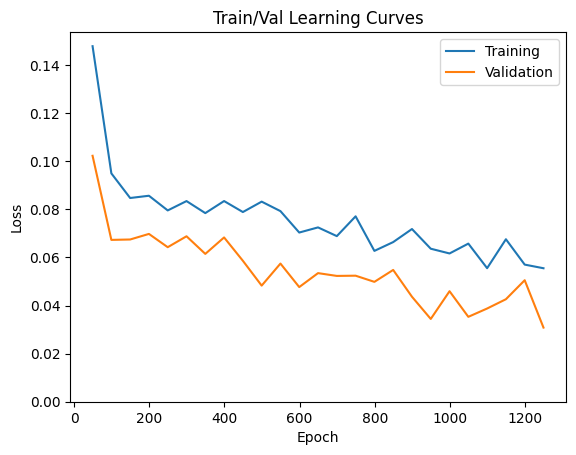

In [229]:
import matplotlib.pyplot as plt

version_num = '85'
year = '2018'
train_lc_path = f'./train_loss_{year}_v{version_num}.csv'
val_lc_path = f'./val_loss_{year}_v{version_num}.csv'
train_lc = pd.read_csv(train_lc_path).drop('Wall time', axis=1)
val_lc = pd.read_csv(val_lc_path).drop('Wall time', axis=1)

# merge dfs into one for easier export
lc_df = train_lc.merge(val_lc, on='Step', suffixes=('_train', '_val'))
lc_df.to_csv(f'./learning_curves_{year}_v{version_num}.csv')

plt.plot(lc_df['Step'].to_numpy(), lc_df['Value_train'].to_numpy(), label='Training')
plt.plot(lc_df['Step'].to_numpy(), lc_df['Value_val'].to_numpy(), label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,)
plt.title('Train/Val Learning Curves')
plt.legend()
plt.show()